In [1]:
import pandas as pd
from simulation import Simulation

from models.building_model import BuildingModel
from models.heat_pump import HeatPump
from models.hyst_controller import HystController
from models.weather_model import LocalWeather

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib ipympl

In [2]:
class HystController():
    def __init__(self, name, delta_t=60, hyst=4, T_set=21, state_0='off') -> None:
        # Parameter
        self.delta_t = delta_t

        self.T_set = T_set 
        self.hyst = hyst

        self.state = state_0

        self.inputs  = ['T_is']
        self.outputs = ['state']

        self.name = name

    def step(self, time, T_is):
        if T_is > self.T_set + self.hyst/2: # upper limit; switch ooff
            self.state = 'off'
        elif T_is < self.T_set - self.hyst/2:  # lower limit, switch on
            self.state = 'on'
        else:
            pass # else leave state as is
        return {'state': self.state}
        

In [6]:
sim = Simulation()

building   = BuildingModel('building')
heatpump   = HeatPump('heatpump')
controller = HystController('controller', hyst=1.2)
weather    = LocalWeather('weather')

sim.add_model(building,   watch_values=['T_room1', 'T_room2', 'T_amb', 'apparent_zenith', 'dhi', 'ghi']  )
sim.add_model(heatpump,   watch_values=['state', 'P_el', 'dot_Q_hp'])
sim.add_model(controller, watch_values=['T_is', 'state'])
sim.add_model(weather,    watch_values=['apparent_zenith', 'dhi', 'ghi'])

sim.connect(weather, building, ('T_air', 'T_amb'), 'apparent_zenith', 'azimuth', 'dni', 'dhi', 'ghi')
sim.connect(weather, heatpump, ('T_air', 'T_source'))
sim.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim.connect(controller, heatpump, ('state', 'state'))

sim.connect(building, heatpump, ('T_room1', 'T_sink'), time_shifted=True, init_values={'T_room1': 21})
sim.connect(building, controller, ('T_room1', 'T_is'), time_shifted=True, init_values={'T_room1': 21})

times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')

sim.run(times)

Progress: 100%|██████████| 2881/2881 [00:05<00:00, 492.39Steps/s]


In [4]:
df = pd.read_pickle('output_data.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'output_data.pkl'

In [24]:
for col in df.columns:
    # Attempt to convert the column to numeric
    df[col] = pd.to_numeric(df[col], errors='ignore')
df.head()

Empty DataFrame
Columns: []
Index: []

KeyError: ('building', 'outputs', 'T_room1')

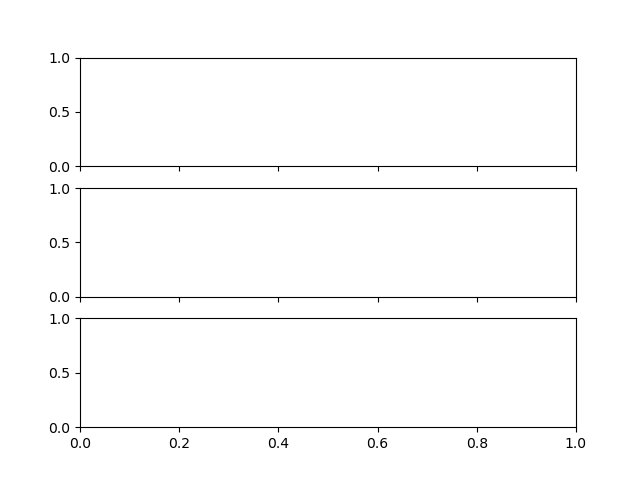

In [21]:
df = df

df.interpolate('ffill', inplace=True)
dtindex = df.index 

fig, ax = plt.subplots(3, sharex=True)
# Roomtemperatures
ax[0].plot(dtindex, df.loc[:, ('building', 'outputs', 'T_room1')], label='T_room1', drawstyle='steps')
ax[0].plot(dtindex, df.loc[:, ('building', 'outputs', 'T_room2')], label='T_room2', drawstyle='steps')
ax[0].plot(dtindex, df.loc[:, ('building', 'inputs', 'T_amb')], label='T_amb', drawstyle='steps')

ax[0].legend()
ax[0].set_ylabel('Temperatures in °C')

ax[1].plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'P_el')], label='P_el', drawstyle='steps')
ax[1].plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')], label='dot_Q_hp', drawstyle='steps')
ax[1].legend()
ax[1].set_ylabel('Power in W')

ax[-1].set_xlabel('Time')
ax[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[-1].xaxis.get_major_locator(),))

In [14]:
sim.draw_execution_visualization()

AttributeError: 'Simulation' object has no attribute 'draw_execution_visualization'